In [1]:
#sparting spark and reading Reddit
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Reddit").getOrCreate()
df = None
df = spark.read.csv("s3a://andrew-bierbaum-insight-test-dataset/HackerNews/hacker_news_full-000*.csv.gz", header=True,multiLine=True, escape='"')

In [2]:
#spark.sql.caseSensitive = False
#sqlContext.sql("set spark.sql.caseSensitive=false")

In [3]:
#showing the start of the data and format
df.show(5)
df.printSchema()

+-------------+-----+----------+--------------------+-----+-------+----+--------------------+--------+-------+----+-----------+--------+-------+
|           by|score|      time|           timestamp|title|   type| url|                text|  parent|deleted|dead|descendants|      id|ranking|
+-------------+-----+----------+--------------------+-----+-------+----+--------------------+--------+-------+----+-----------+--------+-------+
|      jonpugh| null|1470011203|2016-08-01 00:26:...| null|comment|null|I still can&#x27;...|12198470|   null|null|       null|12199585|   null|
|mnemonicsloth| null|1283987630|2010-09-08 23:13:...| null|comment|null|<a href="http://y...| 1673082|   null|null|       null| 1673847|   null|
|         null| null|1464793231|2016-06-01 15:00:...| null|comment|null|                null|11812488|   true|null|       null|11814825|   null|
|  maxerickson| null|1493134717|2017-04-25 15:38:...| null|comment|null|First couple minu...|14194417|   null|null|       null|141

In [4]:
#Convert spark data to be readable using sql queries
df.createOrReplaceTempView("HackerNews")
microsoft_results = spark.sql("SELECT time, text FROM HackerNews WHERE text LIKE '%microsoft%'")
facebook_results = spark.sql("SELECT time, text FROM HackerNews WHERE text LIKE '%facebook%'")
amazon_results = spark.sql("SELECT time, text FROM HackerNews WHERE text LIKE '%amazon%'")
google_results = spark.sql("SELECT time, text FROM HackerNews WHERE text LIKE '%google%'")
microsoft_results.show()

+----------+--------------------+
|      time|                text|
+----------+--------------------+
|1463308051|Could be anything...|
|1439461388|As others have sa...|
|1353638659|<i>"Microsoft pro...|
|1429371259|Lobbying from loc...|
|1494207277|Joel Spolsky famo...|
|1532716429|I don&#x27;t thin...|
|1287340736|<a href="http://m...|
|1477677180|Not that I have a...|
|1348621918|Probably Apple ha...|
|1368829768|Firefox gives thi...|
|1343270965|You are completel...|
|1321968941|Sure.<p>&#62;With...|
|1510177005|Yeah, it was a gr...|
|1203406862|This is silly. Th...|
|1359471757|When I can run xc...|
|1286160319|Of course, since ...|
|1277857562|engineers.<p>marc...|
|1535938164|This is similar t...|
|1264769069|If we assume iPad...|
|1535836057|<a href="https:&#...|
+----------+--------------------+
only showing top 20 rows



In [5]:
#collect, convert dates to datetime format for later graphing, and sort data
from datetime import datetime
python_microsoft_results = microsoft_results.collect()
python_microsoft_results_cleaned = [(datetime.fromtimestamp(float(i)),body.encode('ascii',errors='ignore')) for i, body in python_microsoft_results]
python_microsoft_results_cleaned.sort()

#b = bytes('pythön', encoding='utf-8')
#print(str(b, encoding='ascii', errors='ignore'))

In [6]:
#validation steps

#print python_microsoft_results_cleaned
#print python_microsoft_results_cleaned

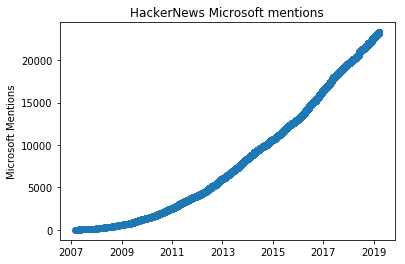

<Figure size 432x288 with 0 Axes>

In [7]:
#sort, number, and then graph the data
%matplotlib inline
import numpy
import matplotlib
import matplotlib.pyplot as plt
count = numpy.arange(len(python_microsoft_results_cleaned))
#Date_Data = matplotlib.dates.datestr2num(clean_python_results_utc)
Date_Data = []
Body_Data = []
for date, body in python_microsoft_results_cleaned:
    Date_Data.append(date)
    Body_Data.append(body)
matplotlib.pyplot.plot_date(Date_Data,count,xdate=True, drawstyle = 'steps-pre', linestyle = 'solid' )
matplotlib.pyplot.ylabel('Microsoft Mentions')
matplotlib.pyplot.title('HackerNews Microsoft mentions')
plt.show()
plt.savefig('HackerNews.png')


In [8]:
#import csv
import pandas

# with open('dash.csv', 'w') as csvfile:   #, newline=''
#     #csv.writer(csvfile, delimiter=' ', quotechar='|', quoting=csv.QUOTE_MINIMAL)
#     writer = csv.writer(csvfile)
#     writer.writerows("count","Date_Data")

#zipped_Data = zip(Date_Data, body)
#pandas_df = pandas.DataFrame(zipped_Data)
pandas_df = pandas.DataFrame({'date':Date_Data,'body':Body_Data})
pandas_df.head()
pandas_df.to_csv("HackerNews_Microsoft.csv")

# percentile_list = pd.DataFrame(
#     {'lst1Title': lst1,
#      'lst2Title': lst2,
#      'lst3Title': lst3
#     })

In [5]:
# import csv
# import pandas

# pandas_df = pandas.DataFrame(python_results_timestamp, columns = ['count, timestamp'])
# pandas_df.show()

In [6]:
# import dash
# import dash_core_components as dcc
# import dash_html_components as html

# external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

# app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

# app.layout = html.Div(children=[
#     html.H1(children='Reddit 2006'),

#     html.Div(children='''
#         Dash: A web application framework for Python.
#     '''),

#     dcc.Graph(
#         id='Reddit 2006 python mentions',
#         figure={
#             'data': [
#                 {'x': Date_Data, 'y': count, 'type': 'scatter', 'name': 'SF'}
#             ],
#             'layout': {
#                 'title': 'Dash Data Visualization'
#             }
#         }
#     )
# ])

# if __name__ == '__main__':
#     app.run_server(debug=True, port = 9990, host ='0.0.0.0')